#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 06
**CH06A Comparing Online and Offline Prices: Testing the Difference**

billion-prices dataset dataset

version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas
import seaborn as sns
from mizani.formatters import percent_format
from plotnine import *

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/billion-prices/clean/"
data_out = dirname + "da_case_studies/ch06-online-offline-price-test/"
output = dirname + "da_case_studies/ch06-online-offline-price-test/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions
from py_helper_functions import *

In [4]:
pd = pandas.read_csv(data_in + "online_offline_ALL_clean.csv", encoding="latin1")

In [7]:
# FILTER DATA
pd = pd.loc[
    lambda x: (x["COUNTRY"] == "USA")
    & (x["PRICETYPE"] == "Regular Price")
    & (x["sale_online"].isnull())
    & (~x["price"].isnull())
    & (~x["price_online"].isnull())
]

In [8]:
# Drop obvious errors
pd = pd.loc[lambda x: x["price"] < 1000]

In [9]:
# Compare variables
pd["diff"] = pd["price_online"] - pd["price"]
descr = pd["diff"].describe()

In [10]:
descr

count    6439.000000
mean        0.054460
std         9.994452
min      -380.130000
25%        -0.040000
50%         0.000000
75%         0.000000
max       415.270000
Name: diff, dtype: float64

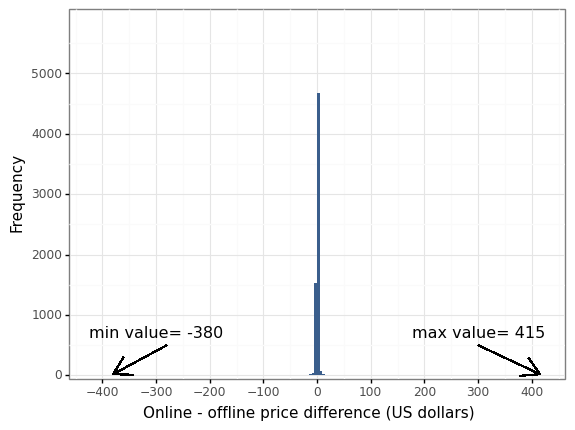

<ggplot: (324423656)>

In [11]:
ggplot(pd, aes("diff")) + geom_histogram(
    binwidth=5,
    boundary=0,
    fill=color[0],
    size=0.25,
    alpha=0.8,
    show_legend=False,
    na_rm=True,
    closed="left"
) + labs(
    x="Online - offline price difference (US dollars)", y="Frequency"
) + theme_bw() + scale_x_continuous(
    limits=(-420, 420), breaks=seq(-400, 420, by=100)
) + scale_y_continuous(
    limits=(0, 6000), breaks=seq(0, 6000, by=1000), expand=(0.01, 0.01)
) + geom_segment(
    aes(x=300, y=500, xend=415, yend=20), arrow=arrow()
) + annotate(
    "text", x=300, y=700, label="max value= 415", size=11.5
) + geom_segment(
    aes(x=-280, y=500, xend=-380, yend=20), arrow=arrow()
) + annotate(
    "text", x=-300, y=700, label="min value= -380", size=11.5
)

In [12]:
# 4.99999 not 5 -- needed because of data imported from stata may be stored wierdly.
pd1 = pd.query("abs(diff)<4.999999")
pd1["diff"].describe()

count    6200.000000
mean       -0.127437
std         0.788358
min        -4.900000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.990000
Name: diff, dtype: float64

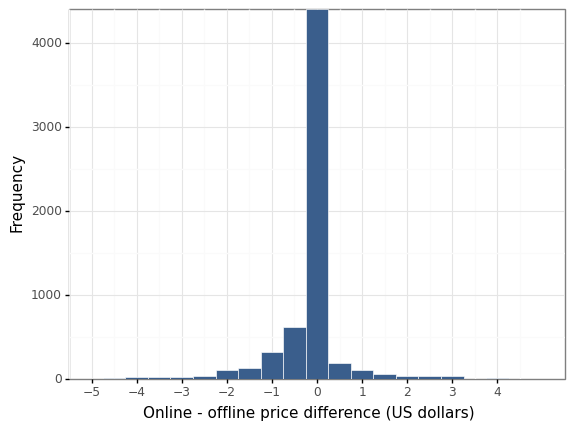

<ggplot: (325025488)>

In [13]:
ggplot(pd, aes("diff")) + geom_histogram(
    binwidth=0.5,
    center=0.5,
    color="white",
    fill=color[0],
    size=0.25,
    alpha=0.8,
    show_legend=False,
    na_rm=True
) + labs(
    x="Online - offline price difference (US dollars)", y="Frequency"
) + theme_bw() + expand_limits(
    x=0.01, y=0.01
) + scale_x_continuous(
    limits=(-5, 5), breaks=seq(-5, 5, by=1)
) + scale_y_continuous(
    expand=(0.00, 0.00)
)

In [14]:
# HYPOTHESIS
from scipy import stats

stats.ttest_1samp(pd["diff"], 0)

Ttest_1sampResult(statistic=0.43724812660292617, pvalue=0.661946076619305)

In [15]:
def t_test_1samp(series, mu=0):
    """
    This is a function to calculate t_test for 1 sample.
    Return: tuple of 2 elements, first is sample mean, second is t test object from scipy
    """
    return (np.mean(series), stats.ttest_1samp(series, mu))

In [16]:
# MULTIPLE HYPOTHESES
spd = [pd.loc[pd["retailer"] == x,] for x in set(pd["retailer"])]
out = [(set(x["retailer"]), t_test_1samp(x["diff"], 0)) for x in spd]

In [17]:
out

[({44},
  (3.73675,
   Ttest_1sampResult(statistic=2.0970967695735117, pvalue=0.038102345149389))),
 ({45},
  (-1.2166300366300367,
   Ttest_1sampResult(statistic=-1.2271928388565805, pvalue=0.22027995382690432))),
 ({46},
  (-0.4290707648320227,
   Ttest_1sampResult(statistic=-11.641716539786147, pvalue=5.8008651517374406e-30))),
 ({47},
  (0.051625239005736144,
   Ttest_1sampResult(statistic=1.6613855468290473, pvalue=0.09723645884012402))),
 ({48},
  (0.42059701492537316,
   Ttest_1sampResult(statistic=2.132197897818741, pvalue=0.03390329067089751))),
 ({49},
  (2.410042735042735,
   Ttest_1sampResult(statistic=1.2798236568799926, pvalue=0.20187999009028337))),
 ({50},
  (0.606011673151751,
   Ttest_1sampResult(statistic=1.6405334895253019, pvalue=0.10150724842940248))),
 ({51},
  (0.28394321766561514,
   Ttest_1sampResult(statistic=1.8754817018086298, pvalue=0.06164839346391054))),
 ({53},
  (-0.9704273504273504,
   Ttest_1sampResult(statistic=-2.7305459292926293, pvalue=0.00731009

In [18]:
table_out = pandas.DataFrame.from_records(
    [
        {"retailer": list(x[0])[0], "estimate": x[1][0], "p.value": x[1][1].pvalue}
        for x in out
    ]
)

In [19]:
table_out

,retailer,estimate,p.value
0,44,3.736750,3.810235e-02
1,45,-1.216630,2.202800e-01
2,46,-0.429071,5.800865e-30
3,47,0.051625,9.723646e-02
4,48,0.420597,3.390329e-02
5,49,2.410043,2.018800e-01
6,50,0.606012,1.015072e-01
7,51,0.283943,6.164839e-02
8,53,-0.970427,7.310100e-03
9,54,-0.027523,8.004701e-01
